#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/project6/'

In [3]:
import zipfile
zipfile.ZipFile(path + 'train.zip').extractall('/content/train')
zipfile.ZipFile(path + 'test.zip').extractall('/content/test')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/project6/train.zip'

### **(2) 라이브러리 설치 및 불러오기**

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential, Model
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional, Input, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [8]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [10]:
path = '/content/drive/MyDrive/project6'
df_3 = joblib.load(path + '/df_3.pkl')
df_12 = joblib.load(path + '/df_12.pkl')
df_42 = joblib.load(path + '/df_42.pkl')

In [11]:
display(df_3.head(2))
print(df_3.shape)
print('-'*60)
display(df_12.head(2))
print(df_12.shape)
print('-'*60)
display(df_42.head(2))
print(df_42.shape)

,Qty,CustomerCount,PrevQty,SameRegionCustomer,MA7,target,WeekDay_Monday,WeekDay_Saturday,WeekDay_Sunday,WeekDay_Thursday,WeekDay_Tuesday,WeekDay_Wednesday,Weekend_주말
0,8800.0,4254.0,7188.0,2264.0,15606.0,7051.0,0,0,0,0,0,1,0
1,6606.0,3723.0,8800.0,2094.0,15606.0,12599.0,0,0,0,1,0,0,0


(1143, 13)
------------------------------------------------------------


,Qty,CustomerCount,PrevQty,SameRegionCustomer,MA7,target,WeekDay_Monday,WeekDay_Saturday,WeekDay_Sunday,WeekDay_Thursday,WeekDay_Tuesday,WeekDay_Wednesday,Weekend_주말
0,8683.0,4254.0,7124.0,2264.0,14490.0,6992.0,0,0,0,0,0,1,0
1,6731.0,3723.0,8683.0,2094.0,14490.0,11224.0,0,0,0,1,0,0,0


(1143, 13)
------------------------------------------------------------


,Qty,CustomerCount,PrevQty,SameRegionCustomer,MA7,target,WeekDay_Monday,WeekDay_Saturday,WeekDay_Sunday,WeekDay_Thursday,WeekDay_Tuesday,WeekDay_Wednesday,Weekend_주말
0,73.0,4254.0,78.0,2264.0,88.0,96.0,0,0,0,0,0,1,0
1,78.0,3723.0,73.0,2094.0,88.0,67.0,0,0,0,1,0,0,0


(1146, 13)


# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [12]:
# 시계열 데이터 전처리 2차원 --> 3차원으로 변환 함수
def temporalize(x, y, timesteps):
    nfeature = x.shape[1]
    output_x = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        t = []
        for j in range(timesteps):
            t.append(x[[(i + j)], :])
        output_x.append(t)
        output_y.append(y[i + timesteps - 1])
    return np.array(output_x).reshape(-1,timesteps, nfeature), np.array(output_y)

## **(1) LSTM 모델링**

In [31]:
def df_preprocess(df) :
  # x, y 분리
  target = 'target'
  x = df.drop(columns = target)
  y = df.loc[:, target]

  # 스케일링
  scaler = MinMaxScaler()
  x_s = scaler.fit_transform(x)

  y_max, y_min = y.max(), y.min()
  y_s = (y-y_min)/(y_max-y_min)

  # 시계열 데이터 전처리 2차원 --> 3차원으로 변환
  timestep = 14
  x2, y2 = temporalize(x_s, y_s, timestep)

  return x2, y2, y_max, y_min

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [65]:
x2, y2, y_max, y_min = df_preprocess(df_3)

# 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size=120, shuffle = False)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1010, 14, 12), (1010,), (120, 14, 12), (120,))

* **모델링**

In [66]:
timesteps = x_train.shape[1]
nfeatures = x_train.shape[2]

clear_session()
model1 = Sequential([Input(shape = (timesteps, nfeatures)),
                     LSTM(4, return_sequences=True),
                     Dropout(0.2),
                     Flatten(),
                     Dense(4, activation = 'relu'),
                     Dense(1)])

es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model1.compile(optimizer=Adam(learning_rate = 0.01), loss='mse')
hist = model1.fit(x_train, y_train, epochs = 100, validation_data=(x_val, y_val), callbacks=[es]).history

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0474 - val_loss: 0.0143
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - val_loss: 0.0138
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099 - val_loss: 0.0137
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - val_loss: 0.0111
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0070 - val_loss: 0.0115
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0110
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0104
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - val_loss: 0.0127
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0063 - val_loss: 0.0107
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0063 - val_loss: 0.0110
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0057 - val_loss: 0.0114
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0

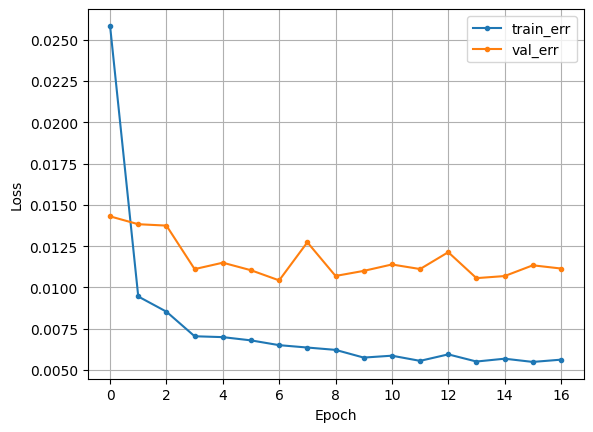

In [67]:
dl_history_plot(hist)

In [68]:
# 예측
pred1 = model1.predict(x_val)

# y를 원래대로 돌려 놓기
y_val_real = y_val * (y_max - y_min) + y_min
pred_real  = pred1 * (y_max - y_min) + y_min

print(f'MAE:{mean_absolute_error(y_val_real, pred_real)}')
print(f'RMSE:{root_mean_squared_error(y_val_real, pred_real)}')
print(f'MAPE:{mean_absolute_percentage_error(y_val_real, pred_real)}')
print(f'R2_Score:{r2_score(y_val_real, pred_real)}')
#이틀 후의 판매량을 예측할 때 오차가 1648 차이 난다.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
MAE:1786.6683837890625
RMSE:2594.709343000558
MAPE:4.6547040443602477e+17
R2_Score:0.4785370125603614


### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [69]:
x2, y2, y_max, y_min = df_preprocess(df_12)
# 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size=120, shuffle = False)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1010, 14, 12), (1010,), (120, 14, 12), (120,))

* **모델링**

In [70]:
timesteps = x_train.shape[1]
nfeatures = x_train.shape[2]

clear_session()
model1 = Sequential([Input(shape = (timesteps, nfeatures)),
                     LSTM(4, return_sequences=True),
                     Dropout(0.2),
                     Flatten(),
                     Dense(4, activation = 'relu'),
                     Dense(1)])

es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model1.compile(optimizer=Adam(learning_rate = 0.01), loss='mse')
hist = model1.fit(x_train, y_train, epochs = 100, validation_data=(x_val, y_val), callbacks=[es]).history

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0275 - val_loss: 0.0112
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - val_loss: 0.0129
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - val_loss: 0.0084
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0089
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0107
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0117
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - val_loss: 0.0103
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0108
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0105
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0089
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - val_loss: 0.0096
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

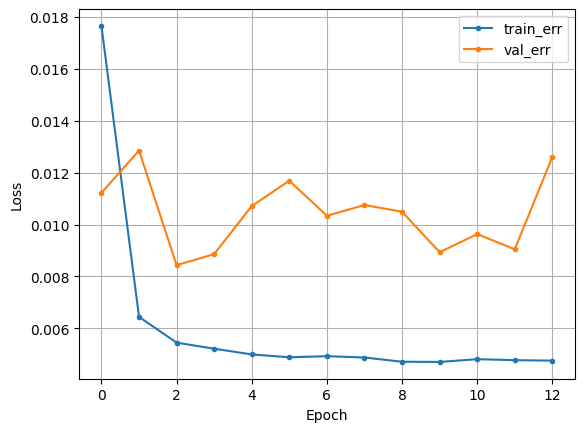

In [71]:
dl_history_plot(hist)

In [72]:
# 예측
pred1 = model1.predict(x_val)

# y를 원래대로 돌려 놓기
y_val_real = y_val * (y_max - y_min) + y_min
pred_real  = pred1 * (y_max - y_min) + y_min

print(f'MAE:{mean_absolute_error(y_val_real, pred_real)}')
print(f'RMSE:{root_mean_squared_error(y_val_real, pred_real)}')
print(f'MAPE:{mean_absolute_percentage_error(y_val_real, pred_real)}')
print(f'R2_Score:{r2_score(y_val_real, pred_real)}')
#이틀 후의 판매량을 예측할 때 오차가 1648 차이 난다.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
MAE:2370.4271321614583
RMSE:3408.2056136491487
MAPE:5.483646751261502e+17
R2_Score:0.17789665201013105


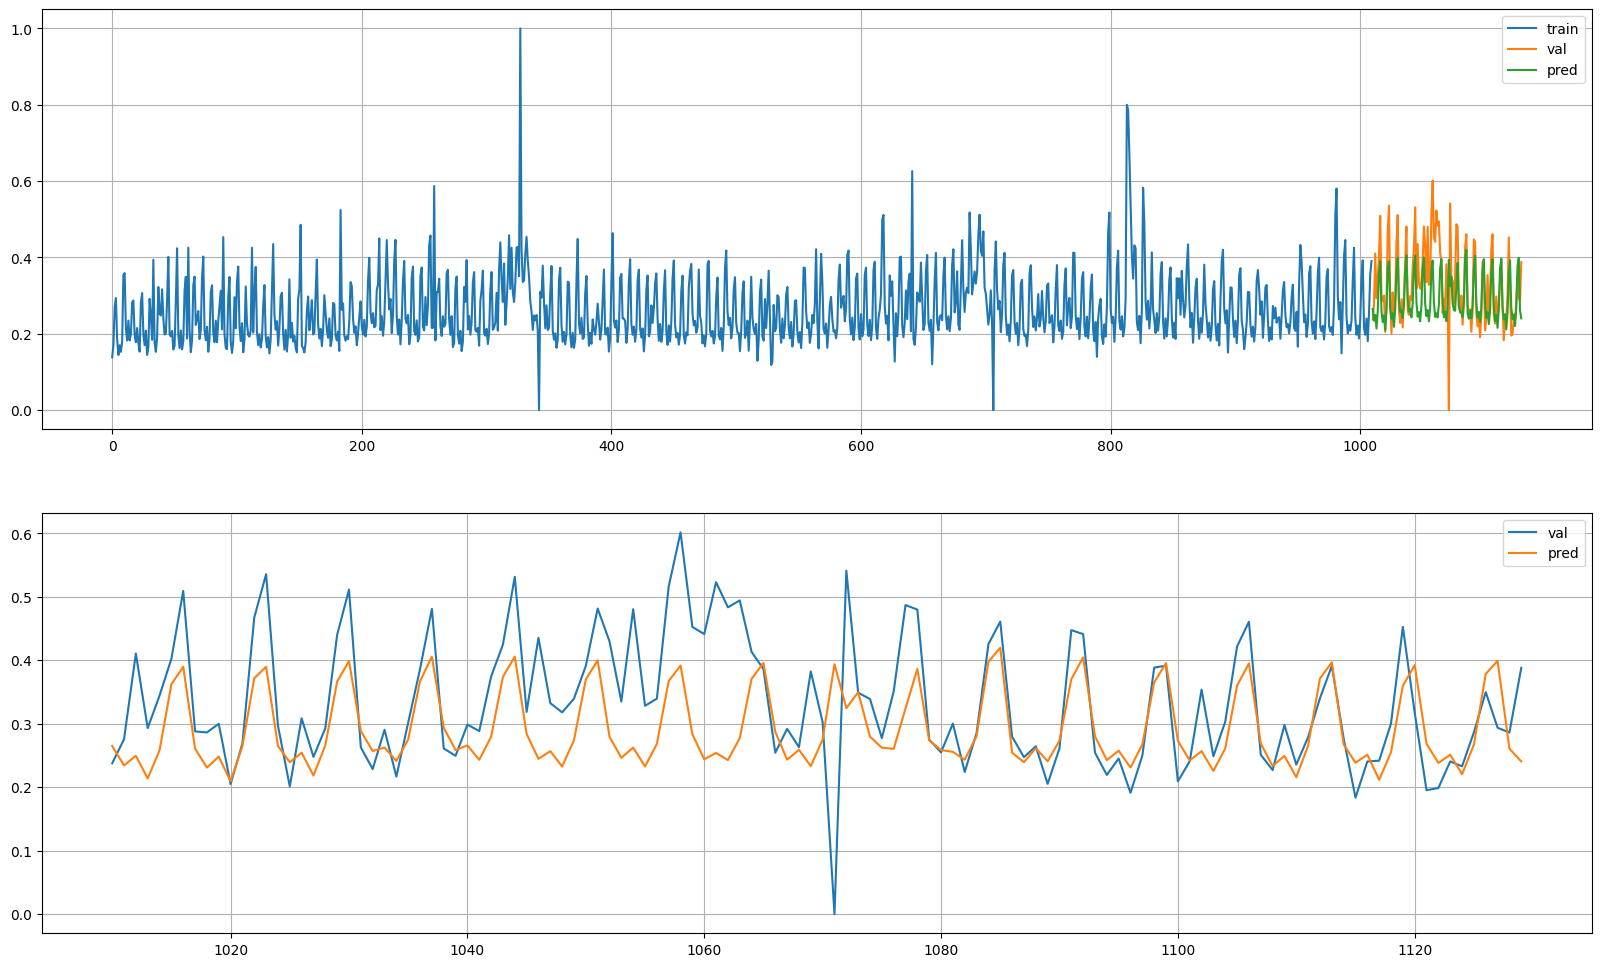

In [73]:
plot_model_result(y_train, y_val, pred1)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [74]:
x2, y2, y_max, y_min = df_preprocess(df_42)

# 데이터 분할
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size=120, shuffle = False)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1013, 14, 12), (1013,), (120, 14, 12), (120,))

* **모델링**

In [75]:
timesteps = x_train.shape[1]
nfeatures = x_train.shape[2]

clear_session()
model1 = Sequential([Input(shape = (timesteps, nfeatures)),
                     LSTM(4, return_sequences=True),
                     Dropout(0.2),
                     Flatten(),
                     Dense(4, activation = 'relu'),
                     Dense(1)])

es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model1.compile(optimizer=Adam(learning_rate = 0.01), loss='mse')
hist = model1.fit(x_train, y_train, epochs = 100, validation_data=(x_val, y_val), callbacks=[es]).history

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1234 - val_loss: 0.0173
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0164 - val_loss: 0.0122
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0151 - val_loss: 0.0107
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0123 - val_loss: 0.0099
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121 - val_loss: 0.0119
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106 - val_loss: 0.0111
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098 - val_loss: 0.0093
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0106
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - val_loss: 0.0092
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

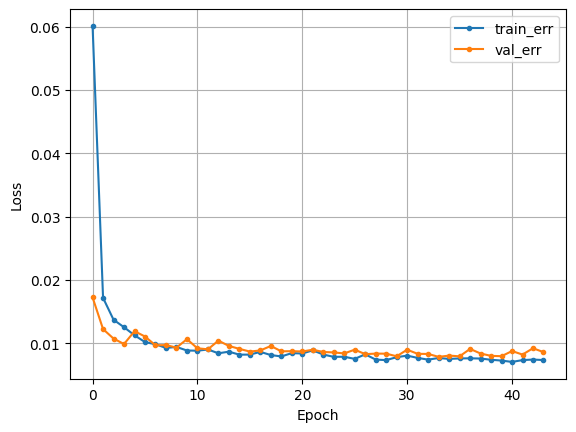

In [76]:
dl_history_plot(hist)

In [77]:
# 예측
pred1 = model1.predict(x_val)

# y를 원래대로 돌려 놓기
y_val_real = y_val * (y_max - y_min) + y_min
pred_real  = pred1 * (y_max - y_min) + y_min

print(f'MAE:{mean_absolute_error(y_val_real, pred_real)}')
print(f'RMSE:{root_mean_squared_error(y_val_real, pred_real)}')
print(f'MAPE:{mean_absolute_percentage_error(y_val_real, pred_real)}')
print(f'R2_Score:{r2_score(y_val_real, pred_real)}')
#이틀 후의 판매량을 예측할 때 오차가 1648 차이 난다.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
MAE:10.304814275105795
RMSE:13.383996173174568
MAPE:0.1075632204999611
R2_Score:0.6649606827479392


## **(2) CNN 모델링**

In [80]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [81]:
def df_preprocess(df) :
  # x, y 분리
  target = 'target'
  x = df.drop(columns = target)
  y = df.loc[:, target]

  # 스케일링
  scaler = MinMaxScaler()
  x_s = scaler.fit_transform(x)

  y_max, y_min = y.max(), y.min()
  y_s = (y-y_min)/(y_max-y_min)

  # 시계열 데이터 전처리 2차원 --> 3차원으로 변환
  timestep = 14
  x2, y2 = temporalize(x_s, y_s, timestep)

  return x2, y2, y_max, y_min


In [108]:
# CNN함수
def CNN_MODEL(df):
    # 데이터 전처리
    x2, y2, y_max, y_min = df_preprocess(df)
    x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size=120, shuffle=False)

    # CNN 모델 정의
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val))

    y_pred = model2.predict(x_val)
    y_val_real = y_val * (y_max - y_min) + y_min
    y_pred_real = y_pred * (y_max - y_min) + y_min

    rmse = np.sqrt(mean_squared_error(y_val_real, y_pred_real))
    mae = mean_absolute_error(y_val_real, y_pred_real)
    mape = np.mean(np.abs((y_val_real - y_pred_real) / y_val_real)) * 100
    r2 = r2_score(y_val_real, y_pred_real)
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}%")
    print(f"R2 Score: {r2}")


### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [109]:
CNN_MODEL(df_3)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0298 - mae: 0.1326 - val_loss: 0.0174 - val_mae: 0.0995
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143 - mae: 0.0910 - val_loss: 0.0141 - val_mae: 0.0864
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140 - mae: 0.0892 - val_loss: 0.0143 - val_mae: 0.0861
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - mae: 0.0889 - val_loss: 0.0124 - val_mae: 0.0776
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - mae: 0.0792 - val_loss: 0.0143 - val_mae: 0.0885
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - mae: 0.0720 - val_loss: 0.0138 - val_mae: 0.0837
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - mae: 0.0769 - val_loss: 0.0233 - val_mae: 0.1274
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - mae: 0.0803 - val_loss: 0.0157 - val_mae: 0.0932
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - mae:

NameError: name 'model2' is not defined

* **모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

In [ ]:
CNN_MODEL(df_12)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [84]:
CNN_MODEL(df_42)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.1731 - mae: 0.3025 - val_loss: 0.0108 - val_mae: 0.0826
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0246 - mae: 0.1214 - val_loss: 0.0095 - val_mae: 0.0735
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203 - mae: 0.1100 - val_loss: 0.0118 - val_mae: 0.0841
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221 - mae: 0.1158 - val_loss: 0.0093 - val_mae: 0.0728
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0196 - mae: 0.1100 - val_loss: 0.0129 - val_mae: 0.0883
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0214 - mae: 0.1150 - val_loss: 0.0089 - val_mae: 0.0703
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0194 - mae: 0.1086 - val_loss: 0.0095 - val_mae: 0.0751
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 - mae: 0.1005 - val_loss: 0.0090 - val_mae: 0.0703
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0179 - mae:

* **모델링**

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data(sales_test, orders_test, oil_price_test, products, stores)
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

In [116]:
# 시계열 데이터 전처리 2차원 --> 3차원으로 변환 함수
def temporalize(x, y, timesteps):
    nfeature = x.shape[1]
    output_x = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        t = []
        for j in range(timesteps):
            t.append(x[[(i + j)], :])
        output_x.append(t)
        output_y.append(y[i + timesteps - 1])
    return np.array(output_x).reshape(-1,timesteps, nfeature), np.array(output_y)

In [117]:
def make_scalers(data1, data2, data3):
    scalers = []
    for df in [data1, data2, data3]:
        # x, y 분리
        target = 'target'
        x = df.drop(columns = target)
        y = df.loc[:, target]

        # 스케일링
        scaler = MinMaxScaler()
        x_s = scaler.fit(x)
        y_max, y_min = y.max(), y.min()

        scalers.append([scaler, y_max, y_min])

    return scalers

scaler_3, scaler_12, scaler_42 = make_scalers(df_3, df_12, df_42)

In [118]:
def pipline(sales, orders, oil_price, products, stores, Product_ID, scaler_package, Store_ID = 44):

  df_sales = sales[(sales['Store_ID'] == Store_ID) & (sales['Product_ID'] == Product_ID)].reset_index(drop=True)
  df_orders = orders[orders['Store_ID'] == Store_ID]
  df_products = products[products['Product_ID'] == Product_ID]
  df_stores = stores[stores['Store_ID'] == Store_ID]

  # sales, orders, products 병합
  df = pd.merge(df_sales, df_orders, on=['Date', 'Store_ID'], how='left')
  df = pd.merge(df, df_products, on = 'Product_ID', how = 'left')
  df = pd.merge(df, df_stores, on = 'Store_ID', how = 'left')

  # 연, 월, 일, 요일, 분기 변수 추가 -> 추후 요일과 주말여부 변수만 사용
  df['year'] = df['Date'].apply(lambda x:x.year)
  df['month'] = df['Date'].apply(lambda x:x.month)
  df['day'] = df['Date'].apply(lambda x:x.day)
  df['dayname'] = df['Date'].apply(lambda x:x.day_name())
  df['quarter'] = np.where(df['month'].isin([1,2,3]), 1, np.where(df['month'].isin([4,5,6]), 2, np.where(df['month'].isin([7,8,9]), 3, 4)))

  df['weekday'] = df['Date'].dt.weekday
  df['weekend'] = np.where(df['weekday'] < 5, '주중', '주말')

  # 전일 판매량 -> 변수 추가
  df['previous_qty'] = df['Qty'].shift(1).fillna(method = 'bfill')

  # 전주 동일 판매량 -> 변수 추가
  df['lastweek_qty'] = df['Qty'].shift(7).fillna(method = 'bfill')

  # 같은 지역 매장 고객 방문 수 -> 변수 추가
  region = stores[stores['Store_ID'] == Store_ID]['State'].values[0] #\tMinnesota
  same_region_ID = stores[stores['State'] == region]['Store_ID'].values
  same_region_ID = [i for i in same_region_ID if i != Store_ID]

  same_region_cust = orders[orders['Store_ID'].isin(same_region_ID)].groupby('Date', as_index = False)['CustomerCount'].mean()
  customer = pd.merge(df['Date'], same_region_cust, on = 'Date', how = 'left')
  customer.fillna(0, inplace = True)

  df['same_region_customer'] = customer['CustomerCount'].values.round(0)

  # 7일 이동평균 판매량 -> 변수 추가
  df['MA7'] = df['Qty'].rolling(window=7).max().fillna(method = 'bfill')

  # CustomerCount 결측치 처리
  ## Qty(판매량)이 0이면 CustomerCount 0으로 대체
  ## Qty(판매량)이 0이 아니면 na 행에 해당하는 Qty(판매량)의 최소값과 최대값를 구하고 구간에 속하는 CustomerCount의 평균값으로 대체
  qty_na_max = df[df['CustomerCount'].isna()]['Qty'].max()
  qty_na_min = df[df['CustomerCount'].isna()]['Qty'].min()

  for i in df[df['CustomerCount'].isna()].index :
    if df.loc[i,'Qty'] == 0 :
      df.loc[i, 'CustomerCount'] = 0
    else :
      mean_value = df[df['Qty'].between(qty_na_min, qty_na_max, inclusive = 'both')]['CustomerCount'].mean().round(0)
      df.loc[i, 'CustomerCount'] = mean_value

  # 상위 7행 제외 (Nan 값이므로)
  #df = df[7:].reset_index(drop = True)

  # 필요한 변수 추출
  df = df[['Qty','CustomerCount','dayname','previous_qty','same_region_customer','weekend','MA7']]
  df['target'] = df['Qty'].shift(-2)
  # df['dayname'] = df['dayname'].shift(-2)
  # df['weekend'] = df['weekend'].shift(-2)

  # 변수명 변경
  df.rename(columns = {'month':'Month', 'lastweek_qty':'LastWeekQty','previous_qty':'PrevQty',
                      'dayname':'WeekDay', 'weekend':'Weekend', 'same_region_customer':'SameRegionCustomer'}, inplace = True)

  # 하위 2행 제외 (Nan 값이므로)
  df = df[:-2]

  # 가변수화
  df = pd.get_dummies(df, columns = ['WeekDay','Weekend'], drop_first = True, dtype = int)

  # weekend_주중 : 1, 주말 : 0으로 되어 있어 -> 주말 : 1로 변경
  df['Weekend_주말'] = df['Weekend_주중'].map({1:0, 0:1})
  df.drop(columns = 'Weekend_주중', inplace = True)

  # x, y 분리
  target = 'target'
  x = df.drop(columns = target)
  y = df.loc[:, target]

  # 스케일링
  # scaler = MinMaxScaler() : 학습 데이터 scaler 사용
  scaler, y_max, y_min = scaler_package
  x_s = scaler.transform(x)

  # y_max, y_min = y.max(), y.min() : 학습 데이터 scaler 사용
  y_s = (y-y_min)/(y_max-y_min)

  # 시계열 데이터 전처리 2차원 --> 3차원으로 변환
  timestep = 14
  x2, y2 = temporalize(x_s, y_s, timestep)

  return x2, y2, y_max, y_min

## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [106]:
# 데이터 불러오기
path = '/content/drive/MyDrive/project6/'
oil_price = pd.read_csv(path + 'test/oil_price_test.csv')
orders = pd.read_csv(path + 'test/orders_test.csv')
sales = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores= pd.read_csv(path + 'test/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [122]:
x_test, y_test, y_max, y_min = pipline(sales, orders, oil_price, products, stores, Product_ID = 12, scaler_package=scaler_12)

* 예측해보기

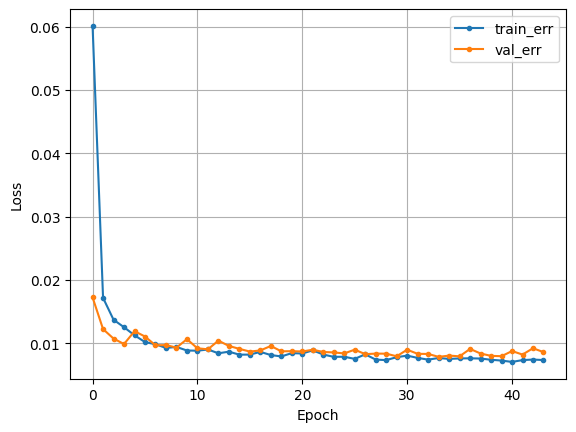

In [123]:
dl_history_plot(hist)

In [126]:
# 예측
pred1 = model1.predict(x_test)

# y를 원래대로 돌려 놓기
y_test_real = y_test * (y_max - y_min) + y_min
pred_real  = pred1 * (y_max - y_min) + y_min

print(f'MAE:{mean_absolute_error(y_test_real, pred_real)}')
print(f'RMSE:{root_mean_squared_error(y_test_real, pred_real)}')
print(f'MAPE:{mean_absolute_percentage_error(y_test_real, pred_real)}')
print(f'R2_Score:{r2_score(y_test_real, pred_real)}')
#이틀 후의 판매량을 예측할 때 오차가 1522 차이 난다.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE:1857.7346801757812
RMSE:2191.0488927663396
MAPE:0.17810570085791416
R2_Score:0.574497047391431


# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [130]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


In [132]:
inv_simulator(y_test_real, pred_real, 30, 6)

일평균 재고량     : 5544.679
일평균 재고 금액  : 33268.074
일평균 재고회전율 : 1.788
기회손실 수량     : -19158.0


,y,pred,base_stock,close_stock,order,receive,lost
0,8592.0,10272.0,8622,30,11681,8592,0.0
1,11463.0,11569.0,11493,30,14040,11463,0.0
2,16763.0,11681.0,11711,0,7578,11681,-5052.0
3,16948.0,14040.0,14040,0,8244,14040,-2908.0
4,9052.0,7548.0,7578,0,8561,7578,-1474.0
5,8945.0,8214.0,8244,0,10322,8244,-701.0
6,9165.0,8531.0,8561,0,11911,8561,-604.0
7,8075.0,10292.0,10322,2247,9606,10322,0.0
8,9876.0,11881.0,14158,4282,9896,11911,0.0
9,15023.0,11823.0,13888,0,7535,9606,-1135.0
